In [11]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval)
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import juanfit

In [12]:
with Image.open("../../sav/Eclipse/Video/frame112.jpg") as im:
    totality_context = np.asarray(im)

with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos.h5", 'r') as hf:
    sun_x = hf['sun_x'][:]
    sun_y = hf['sun_y'][:]
    rsun = hf['rsun'][:]

n_data_tofit = sun_x.shape[0] - 5
time_index_tofit = np.arange(5,5+n_data_tofit,dtype=np.float64)
sun_x_tofit = sun_x[5:]
sun_y_tofit = sun_y[5:]

sun_x_fitparam = np.polyfit(time_index_tofit, sun_x_tofit, 1)
sun_y_fitparam = np.polyfit(time_index_tofit, sun_y_tofit, 1)
sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [25]:
green_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"
totality_image_green_fname = "TotalitySequenceGreen_22718(3).fit"
totality_green_frame = CCDData.read(os.path.join(green_path, totality_image_green_fname),unit="adu")

In [31]:
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_green.h5", 'r') as hf:
    xpos_map_coordinate_green = hf['xpos_map_coordinate'][:]
    xstart_pixel_green = hf['xpos_map_coordinate'].attrs['xstart_pixel']
    xend_pixel_green = hf['xpos_map_coordinate'].attrs['xend_pixel']

    ypos_map_coordinate_green = hf['ypos_map_coordinate'][:]
    ystart_pixel_green = hf['ypos_map_coordinate'].attrs['ystart_pixel']
    yend_pixel_green = hf['ypos_map_coordinate'].attrs['yend_pixel']

In [27]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_1s_proto.h5", 'r') as hf:
    bias_dc_green_1s = hf['image'][:]

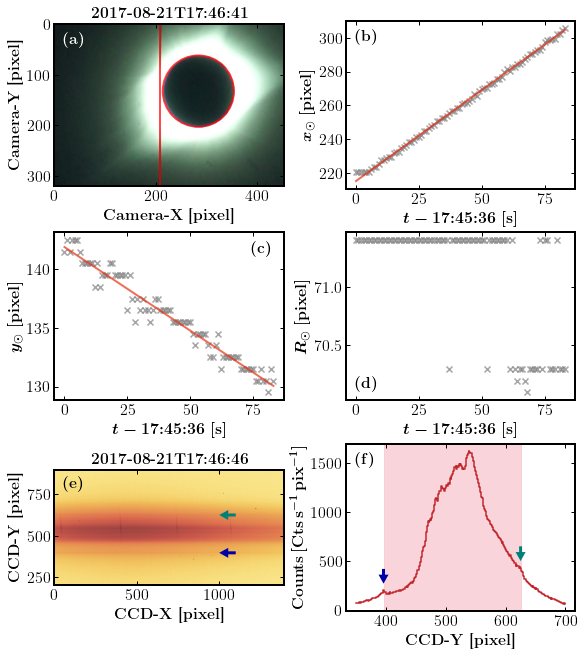

In [89]:
video_vertical_slice =  slice(390,710)
video_horizontal_slice = slice(746,1200)
slit_pos = 209.4

fig, axes = plt.subplots(3,2,figsize=(8,9),constrained_layout=True)

circle_plot = plt.Circle((sun_x[65], sun_y[65]), rsun[65], color='red',fill=False,lw=2,alpha=0.7)

axes[0,0].imshow(np.flip(totality_context[video_vertical_slice,video_horizontal_slice,:],axis=0))
axes[0,0].add_patch(circle_plot)
axes[0,0].axvline(slit_pos,color="red",lw=2,alpha=0.7)
axes[0,0].set_title(r"\textbf{2017-08-21T17:46:41}",fontsize=16)
axes[0,0].set_xlabel(r"\textbf{Camera-X [pixel]}",fontsize=16)
axes[0,0].set_ylabel(r"\textbf{Camera-Y [pixel]}",fontsize=16)
axes[0,0].text(0.04,0.95,r"\textbf{(a)}",ha="left",va="top",color="white",fontsize=16,transform=axes[0,0].transAxes)

axes[0,1].scatter(np.arange(0,sun_x.shape[0],dtype=np.float64),sun_x,marker="x",color="grey",alpha=0.7)
axes[0,1].plot(np.linspace(0,sun_x.shape[0] - 1,100),sun_x_fitpoly(np.linspace(0,sun_x.shape[0] - 1,100)),lw=2,alpha=0.7,color="#E83015")
axes[1,0].scatter(np.arange(0,sun_y.shape[0],dtype=np.float64),sun_y,marker="x",color="grey",alpha=0.7)
axes[1,0].plot(np.linspace(0,sun_y.shape[0] - 1,100),sun_y_fitpoly(np.linspace(0,sun_y.shape[0] - 1,100)),lw=2,alpha=0.7,color="#E83015")
axes[1,1].scatter(np.arange(0,rsun.shape[0],dtype=np.float64),rsun,marker="x",color="grey",alpha=0.7)

axes[0,1].text(0.04,0.95,r"\textbf{(b)}",ha="left",va="top",color="black",fontsize=16,transform=axes[0,1].transAxes)
axes[1,0].text(0.95,0.95,r"\textbf{(c)}",ha="right",va="top",color="black",fontsize=16,transform=axes[1,0].transAxes)
axes[1,1].text(0.04,0.05,r"\textbf{(d)}",ha="left",va="bottom",color="black",fontsize=16,transform=axes[1,1].transAxes)

axes[0,1].set_ylabel(r"$\boldsymbol{x_\odot\ \mathrm{[pixel]}}$",fontsize=16)
axes[1,0].set_ylabel(r"$\boldsymbol{y_\odot\ \mathrm{[pixel]}}$",fontsize=16)
axes[1,1].set_ylabel(r"$\boldsymbol{R_\odot\ \mathrm{[pixel]}}$",fontsize=16)

axes[0,1].set_xlabel(r"$\boldsymbol{t - 17{:}45{:}36\ \mathrm{[s]}}$",fontsize=16)
axes[1,0].set_xlabel(r"$\boldsymbol{t - 17{:}45{:}36\ \mathrm{[s]}}$",fontsize=16)
axes[1,1].set_xlabel(r"$\boldsymbol{t - 17{:}45{:}36\ \mathrm{[s]}}$",fontsize=16)

totality_image_green = (totality_green_frame.data - bias_dc_green_1s)//totality_green_frame.header["EXPTIME"]
norm_green_totality = ImageNormalize(totality_image_green, stretch=LogStretch())
testx_slice_mapcoor = slice(xstart_pixel_green,xend_pixel_green)
testy_slice_mapcoor = slice(ystart_pixel_green,yend_pixel_green)
totality_trans_mapcoor_green = ndimage.map_coordinates(totality_image_green[testy_slice_mapcoor, testx_slice_mapcoor],
                                                       (ypos_map_coordinate_green, xpos_map_coordinate_green),
                                                order=1)

axes[2,0].imshow(totality_image_green[200:900,:],norm=norm_green_totality,cmap=cmcm.lajolla, 
          origin="lower",extent=[-0.5,1391.5,199.5,899.5])
axes[2,0].text(0.04,0.95,r"\textbf{(e)}",ha="left",va="top",color="black",fontsize=16,transform=axes[2,0].transAxes)

axes[2,1].step(np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop), 
        np.mean(totality_trans_mapcoor_green[:,800-xstart_pixel_green:820-xstart_pixel_green],axis=1),where="mid",
        color="#C1272D")
north_limb_green = 625
south_limb_green = 396

axes[2,1].axvspan(south_limb_green, north_limb_green,color="#F8C3CD",alpha=0.7)
axes[2,1].text(0.04,0.95,r"\textbf{(f)}",ha="left",va="top",color="black",fontsize=16,transform=axes[2,1].transAxes)

axes[2,0].annotate("",(1000,south_limb_green),(1100,south_limb_green),
                   arrowprops={"width":3,"headlength":9,"headwidth":10,
                               "ec":"none","fc":"#0000A7"})

axes[2,0].annotate("",(1000,north_limb_green),(1100,north_limb_green),
                   arrowprops={"width":3,"headlength":9,"headwidth":10,
                               "ec":"none","fc":"#008176"})

axes[2,1].annotate("",(south_limb_green,270),(south_limb_green,420),
                   arrowprops={"width":3,"headlength":9,"headwidth":10,
                               "ec":"none","fc":"#0000A7"})

axes[2,1].annotate("",(north_limb_green,500),(north_limb_green,650),
                   arrowprops={"width":3,"headlength":9,"headwidth":10,
                               "ec":"none","fc":"#008176"})


axes[2,0].set_xlabel(r"\textbf{CCD-X [pixel]}",fontsize=16)
axes[2,0].set_ylabel(r"\textbf{CCD-Y [pixel]}",fontsize=16)
axes[2,0].set_title(r"\textbf{" + totality_green_frame.header["DATE-OBS"] + r"}",fontsize=16)

axes[2,1].set_xlabel(r"\textbf{CCD-Y [pixel]}",fontsize=16)
axes[2,1].set_ylabel(r"\textbf{Counts}\,$\boldsymbol{\mathrm{[Cts\,s^{-1}\,pix^{-1}]}}$",fontsize=16)

for ax_ in axes.flatten():
    ax_.tick_params(labelsize=16,direction="in",top=True,right=True)

plt.savefig(fname="../../figs/ms/pointing_coalign.pdf",format="pdf",dpi=300,bbox_inches="tight")